<a href="https://colab.research.google.com/github/raviintechis/Ravi_CNN-for-Handwritten-Letters-Classification/blob/main/Ravi_CNN_for_Handwritten_Letters_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [55]:
from __future__ import division, print_function

import h5py

# Импортируем TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# Display all columns of dataframe
pd.set_option('display.max_columns', None)

In [56]:
#check version of library
import tensorflow as tf
tf.__version__

'2.7.0'

In [57]:
data1 = pd.read_csv("letters.csv")
data2 = pd.read_csv("letters2.csv")
data3 = pd.read_csv("letters3.csv")
print("First dataset shape: {0}, \nSecond dataset shape: {1}, \nThird dataset shape: {2}".format(data1.shape, data2.shape, data3.shape))

First dataset shape: (1650, 4), 
Second dataset shape: (5940, 4), 
Third dataset shape: (6600, 4)


In [58]:
data1.head()

,letter,label,file,background
0,а,1,01_01.png,0
1,а,1,01_02.png,0
2,а,1,01_03.png,0
3,а,1,01_04.png,0
4,а,1,01_05.png,0


In [59]:
# Read the h5 file
f = h5py.File('LetterColorImages_123.h5', 'r')
# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [60]:
# Create tensors and targets of images
img_backgrounds = np.array(f[keys[0]])
img_tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', img_tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', img_backgrounds.shape)

Tensor shape: (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [61]:
# Concatenate series
letters = pd.concat((data1["letter"], data2["letter"]), axis=0, ignore_index=True)
letters = pd.concat((letters, data3["letter"]), axis=0, ignore_index=True)
len(letters)


14190

In [62]:
# Normalize the tensors
img_tensors = img_tensors/255
img_tensors[0][0][0][0]

0.76862746

##Visualization Lets see the distributions of data in dataset to find out if there are any unbalanced classes:

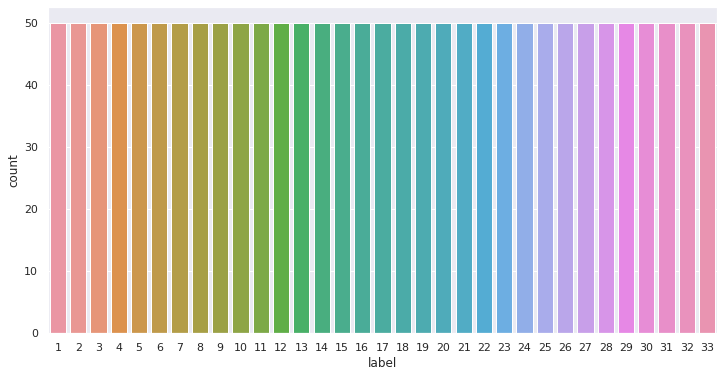

In [63]:
sns.countplot(x="label", data=data1)

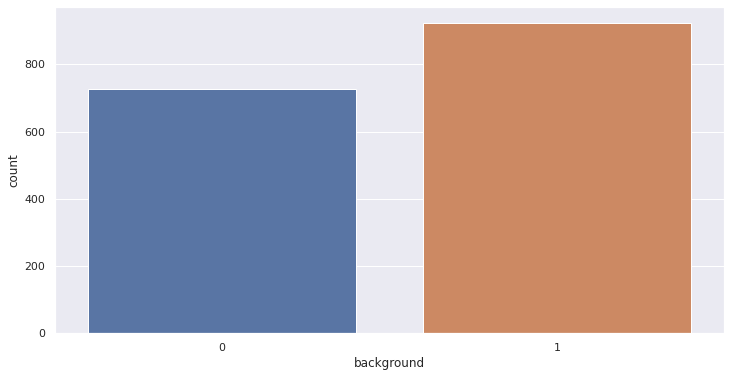

In [64]:
sns.countplot(x="background", data=data1)

Label:  в


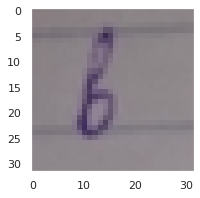

In [65]:
# Read and display a tensor using Matplotlib
sns.set_style("darkgrid", {'axes.grid' : False})
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(img_tensors[100]);

In [66]:
type(img_tensors[0])

numpy.ndarray

In [67]:
img_tensors[0].shape

(32, 32, 3)

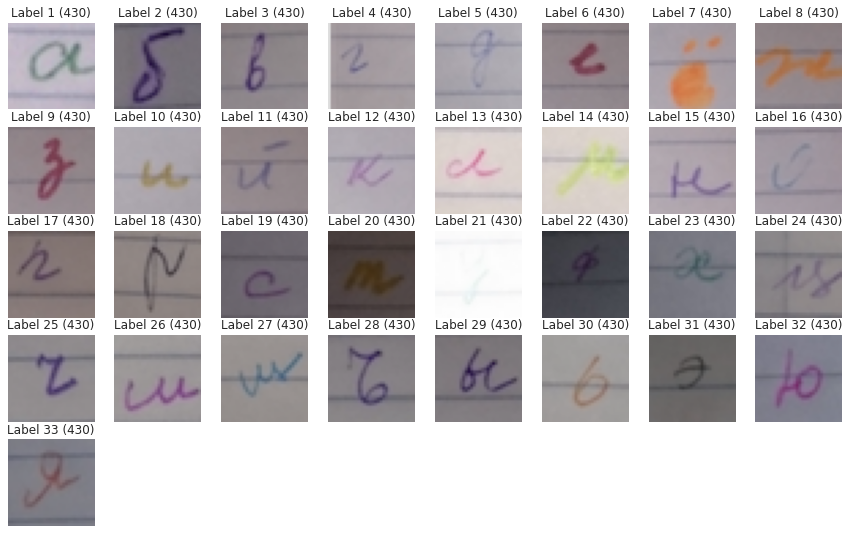

In [68]:
# Display the first image of each label.
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    labels = labels.tolist()
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()
display_images_and_labels(img_tensors, targets)

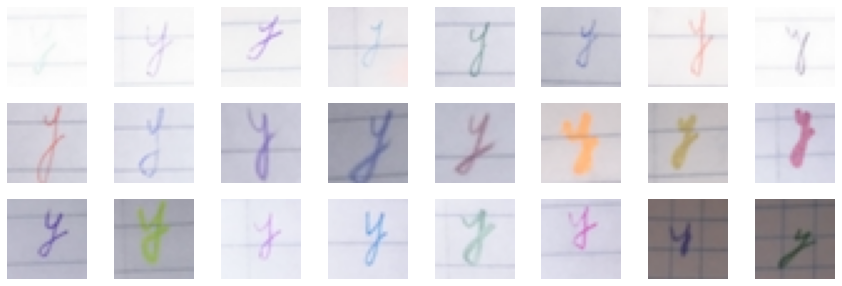

In [69]:
# Display images of a specific label.
def display_label_images(images, labels, label):
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1
    labels = labels.tolist()
    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(img_tensors, targets, 21)

In [70]:
# Display images of a specific label.
def display_images_grayscale(images, labels, label):
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1
    labels = labels.tolist()
    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

####Pre-Proccessing data

In [72]:
# Make dictionary to decode index to letters
dictionary = {'num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], \
              'letter': ['а','б','в','г','д','е','ё','ж','з','и','й','к','л','м','н','о','п','р','с', \
                         'т','у','ф','х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']}
letter_dict = pd.DataFrame.from_dict(dictionary)
letter_dict = letter_dict.set_index("num")
letter_dict.head()

,letter
num,
1,а
2,б
3,в
4,г
5,д


In [74]:
# One-hot encoding the targets, started from the zero label
from tensorflow.keras.utils import to_categorical
coded_targets = to_categorical(np.array(targets-1), 33)
coded_targets.shape

(14190, 33)

##Lets convert RGB image to Grayscale to simplify structure of model of neuron network.

In [77]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [79]:
from tensorflow import image
from tensorflow.image import rgb_to_grayscale
img_tensors_gs_tf = rgb_to_grayscale(img_tensors)

sess = tf.Session()
with sess.as_default():
    print(img_tensors_gs_tf.eval().shape)
    arr_img_tensors_gs_tf = img_tensors_gs_tf.eval()

(14190, 32, 32, 1)


In [80]:
img_tensors_gs = arr_img_tensors_gs_tf
for image in img_tensors_gs[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 1), min: 0.430990606546402, max: 0.7638980746269226
shape: (32, 32, 1), min: 0.4859851002693176, max: 0.6988815665245056
shape: (32, 32, 1), min: 0.33044904470443726, max: 0.738740861415863
shape: (32, 32, 1), min: 0.39237216114997864, max: 0.8238345384597778
shape: (32, 32, 1), min: 0.2929592430591583, max: 0.6343545317649841


In [81]:
img_tensors_gs.shape

(14190, 32, 32, 1)

In [82]:
# Split the data to test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_tensors_gs, coded_targets, test_size = 0.2, random_state = 1)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

Train dataset shape: (11352, 32, 32, 1), 
Test dataset shape: (2838, 32, 32, 1)


In [83]:
# Split the test data to validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)
print("Validation dataset shape: {0}, \nTest dataset shape: {1}".format(X_valid.shape, X_test.shape))

Validation dataset shape: (1419, 32, 32, 1), 
Test dataset shape: (1419, 32, 32, 1)


In [84]:
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU, Softmax
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [85]:
def model():
    model = Sequential()
    
    # Define a model architecture    
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.02))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Global max pooling is ordinary max pooling layer with pool size equals to the size of the input (minus filter size + 1, to be precise). 
    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(33))
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy, top_3_categorical_accuracy])
    return model

model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

##Create callbacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

##ModelCheckpoint - Save the model after every epoch.
ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

##EarlyStopping - Stop training when a monitored quantity has stopped improving.

In [89]:
# Create callbacks
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', verbose=1, save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.75)
# early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callbacks = [checkpointer, lr_reduction]

##Train the model

In [90]:
# Train the model
# batch size = 473 as it divides X_train size, X_test and X_valid sizes evenly
history = model.fit(X_train, y_train, epochs=200, batch_size=473, verbose=1, validation_data=(X_valid, y_valid), callbacks=callbacks) 

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
11352/11352 [==============================] - ETA: 0s - loss: 3.4965 - categorical_accuracy: 0.0271 - top_3_categorical_accuracy: 0.0877
Epoch 00001: val_loss improved from inf to 3.49427, saving model to weights.best.model.hdf5
11352/11352 [==============================] - 28s 2ms/sample - loss: 3.4965 - categorical_accuracy: 0.0271 - top_3_categorical_accuracy: 0.0877 - val_loss: 3.4943 - val_categorical_accuracy: 0.0416 - val_top_3_categorical_accuracy: 0.0937 - lr: 0.0010
Epoch 2/200
11352/11352 [==============================] - ETA: 0s - loss: 3.4804 - categorical_accuracy: 0.0381 - top_3_categorical_accuracy: 0.1064
Epoch 00002: val_loss improved from 3.49427 to 3.47517, saving model to weights.best.model.hdf5
11352/11352 [==============================] - 27s 2ms/sample - loss: 3.4804 - categorical_accuracy: 0.0381 - top_3_categorical_accuracy: 0.1064 - val_loss: 3.4752 - val_categorical_accuracy: 0.0493 - val_top_3

In [91]:
# Plot the Neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['categorical_accuracy'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_categorical_accuracy'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

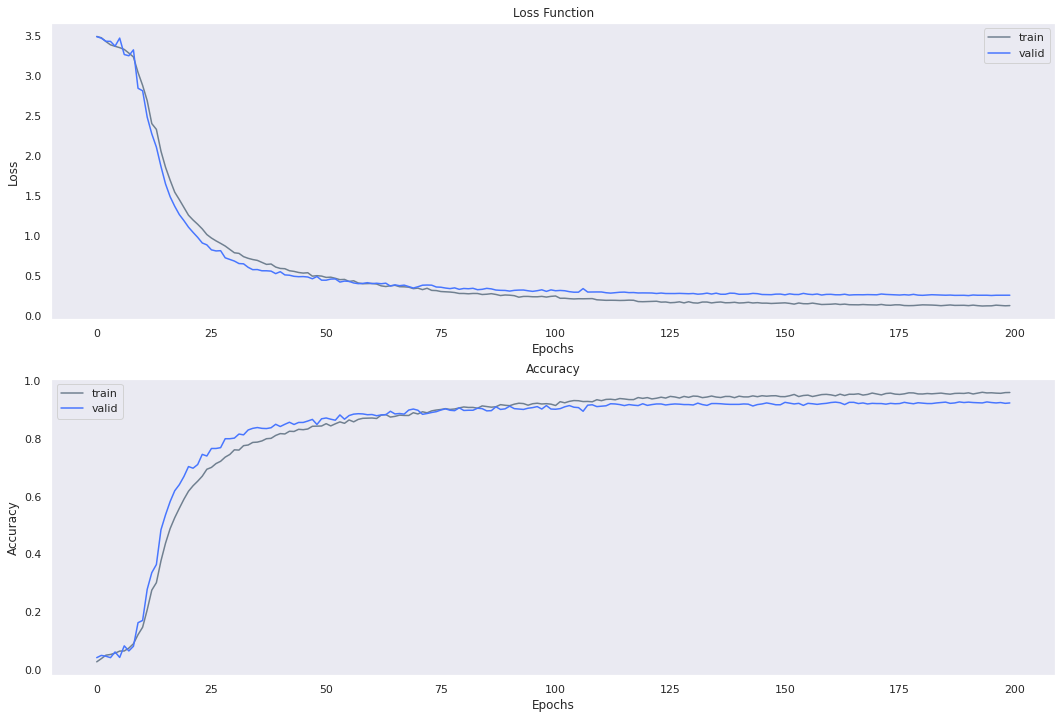

In [92]:
# Plot the training history
history_plot(history, 0)

In [93]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(X_test, y_test)
score

[0.26138447873016074, 0.91966176, 0.98238194]

##Make & Display Predictions

In [95]:
# Model predictions for the testing dataset
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [96]:
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

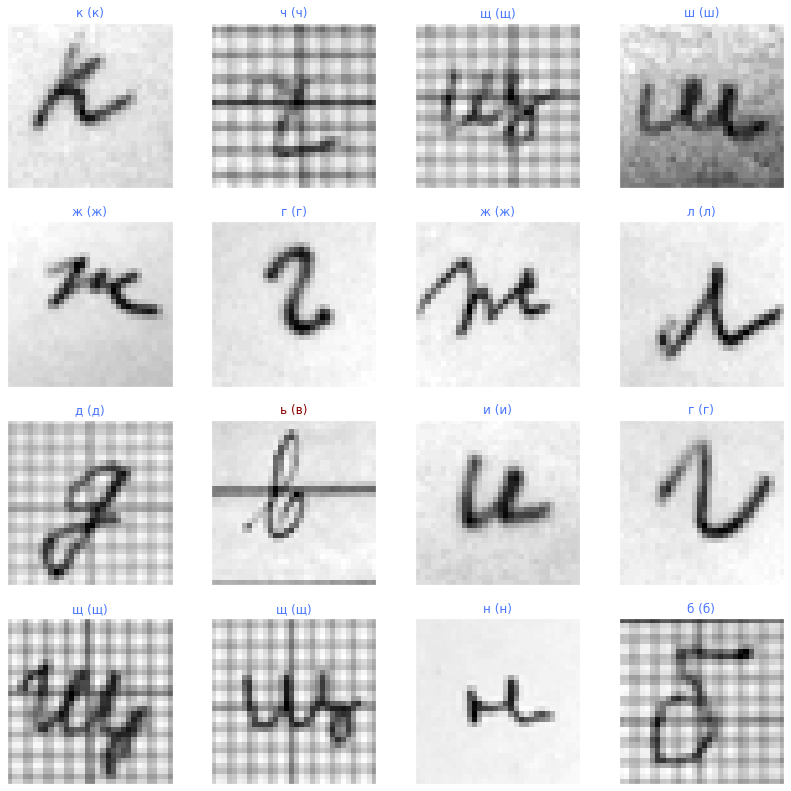

In [99]:
# Display true labels and predictions
fig = plt.figure(figsize=(14, 14))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]), cmap="gray")
    pred_idx = classes_x[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

In [100]:
# Save model
model.save('HW_best_model.h5')